In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt 
from prettytable import PrettyTable 
from gtda.plotting import plot_point_cloud, plot_diagram, plot_heatmap
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, NumberOfPoints, Amplitude, PersistenceImage, HeatKernel




In [2]:
def plot3dEntropyValues(data, labels, groups_per_label, noise):
    output_base_path = "./output/plotEntropy/"
    os.makedirs(output_base_path, exist_ok=True)  # Ensure the directory exists
    colors = ['g', 'y', 'b', 'k', 'pink']
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for i in range(len(labels)):
        data_group = data[groups_per_label*i:groups_per_label*(i+1)]
        ax.scatter([p[0] for p in data_group], 
                [p[1] for p in data_group],
                [p[2] for p in data_group], c=colors[i], label=labels[i])
                
        ax.set_xlabel("H0")
        ax.set_ylabel("H1")
        ax.set_zlabel("H2")
    plt.title(f"Entropy values of data with {noise} noise std")
    plt.legend()
    # Save the figure to the specified output path
    output_file_path = os.path.join(output_base_path, f"plot_entropy_{noise}_noise.png")
    plt.savefig(output_file_path, dpi=300)  # Save as a high-resolution PNG
    plt.show()

In [3]:
def plot3dGeneric(data, data_label, title, axis_labels, save_fig=False, color='b', x_limits=None, y_limits=None, z_limits=None):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    # Scatter plot
    ax.scatter(
        [p[0] for p in data], 
        [p[2] for p in data], 
        [p[1] for p in data], 
        c=color, label=data_label
    )
    
    # Set axis labels
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[2])
    ax.set_zlabel(axis_labels[1])
    
    # Set axis limits if provided
    if x_limits:
        ax.set_xlim(x_limits)
    if y_limits:
        ax.set_ylim(y_limits)
    if z_limits:
        ax.set_zlim(z_limits)
    
    # Set title and legend
    plt.title(title)
    plt.legend()
    
    # Save the figure
    if save_fig:
        output_file_path = os.path.join("BASE_PATH", f"output/{title}.png")
        plt.savefig(output_file_path, dpi=300)
    
    plt.show()

In [4]:
def loadFigures(OPTION, samples, figures, maximum_samples_per_figure, noise_mean=0.0, noise_std=0.01):
    #OPTION : Lets you choose where to get data from 
    #samples : Number of samples per group 
    #figures : The Different Shapes 
    # maximum_samples_per_figure : Maximum number of presampling before shuffling and partitioning
    # #noise_mean, noise_std : Gaussian noise parameters 
    #This function works by first obtaining all or at most maximum_samples_per_figure for each data set of that figure, then shuffling and partitioning them according to sample size
    #Then the function returns a list of data and labels where the ith element of data is a an array of samples, and the ith element of label is the label of the correspoonding figure of 
    # the ith element of data  
    data = []
    labels = []
    for index, figure in enumerate(figures):
        #print(figure)
        data_fig = []
        
        DATASET_DIR = ""
        match(OPTION):
            case "virtual-standard":
                DATASET_DIR = f'../../Datasets/haptic/digital_haptic/21K_random_angles_test/FINGERDIST/1.0/BL/{figure}_VEL_10_NOISE_0.000000.txt'
            case "virtual-face":
                DATASET_DIR = 'haptic_one-side_21k/'+figure+'_VEL_1.txt'
            case "virtual-2.5":
                DATASET_DIR = BASE_PATH + 'new_haptic_system/21K_random_angles_test/FINGERDIST/2.5/BL/'+figure+'_VEL_10_NOISE_0.000000.txt'
            case "real":
                DATASET_DIR = BASE_PATH + 'RealRobot/output/'+figure+'.txt'

        # Read samples
        with open(DATASET_DIR, 'r') as file:
            i = 0
            for line in file:
                # Split each line by spaces and extend the data_list
                sample = np.array(line.split()[0:3], dtype='float32')  # Values
                # Add Gaussian noise to the sample
                noisy_sample = sample + np.random.normal(noise_mean, noise_std, sample.shape)
                data_fig.append(noisy_sample)
                i = i+1
                if (i == maximum_samples_per_figure): 
                    break
        
        #All shuffle
        data_fig = np.array(data_fig)
        #print(f"\tOriginal Data shape: {data_fig.shape}")
        np.random.shuffle(data_fig)
        
        #plot3dGeneric(data_fig, figure, f"Point cloud of figure {figure} - noise std = {noise_std}", ["1st finger", "2nd finger", "3rd finger"], x_limits=(0, 1.2), y_limits=(0, 1.2), z_limits=(0, 0.9))

        minimum = min(int(data_fig.shape[0]/samples), 200)
        #print(f"\t{minimum} groups with {samples} samples each")
        for i in range(minimum):
            group = []
            for j in range(samples):
                group.append(data_fig[i*samples+j])
            if i < 0:
                plot3dGeneric(group, figure, f"Point cloud - {samples} samples of figure {figure} - noise std = {noise_std}", ["1st finger", "2nd finger", "3rd finger"], x_limits=(0, 1.2), y_limits=(0, 1.2), z_limits=(0, 0.9))
            data.append(group)
            labels.append(index)

    # Convert images and labels to numpy arrays
    data = np.array(data, dtype='float32')
    labels = np.array(labels, dtype='float32')

    return data, labels

TDA RElated Calculations

In [5]:
HOMOLOGY_DIMENSIONS = [0, 1, 2]

def getPersistenceDiagrams(data_in):
    persistence = VietorisRipsPersistence(
        metric="euclidean",
        homology_dimensions=HOMOLOGY_DIMENSIONS,
        n_jobs=6,
        collapse_edges=True,
    )
    
    try:
        diagrams = persistence.fit_transform(data_in)
    except Exception as e:
        print(e)
    return diagrams
def getPersistenceEntropy(diagrams_in):
    persistence_entropy = PersistenceEntropy()
    entropy_values = persistence_entropy.fit_transform(diagrams_in)
    return entropy_values

import pandas as pd

def generateTableOfMetrics(diagrams_in, entropy_values, groups_per_label, figures, noise, show=False):
    '''
    diagrams_in : list of persistence diagrams 
    entropy_values : list of entropy values 
    groups_per_label : number of groups per label 

    For every persistence diagram, each metric computes a vector of norms of the each persistence subdiagram (separated according to homology dimension) induced by the metric.
    This fuction then returns a table of the mean of these norms for each figure
    '''
    output_base_path = "./output/metricsTable/"
    os.makedirs(output_base_path, exist_ok=True)  # Ensure the directory exists
    #print("\tNumber of points in process...")
    n_points = NumberOfPoints().fit_transform(diagrams_in)
    #print("\twasserstein in process...")
    wass_dist = Amplitude(metric='wasserstein').fit_transform(diagrams_in)
    #print("\tbottleneck in process...")
    bot_dist = Amplitude(metric='bottleneck').fit_transform(diagrams_in)
    land_dist = Amplitude(metric='landscape').fit_transform(diagrams_in)
    #print("\tlandscape in process...")
    #print("\tpersistence_image in process...")
    #img_dist = Amplitude(metric='persistence_image').fit_transform(diagrams_in)
    #print("\tbett iin process...")
    betti = Amplitude(metric='betti').fit_transform(diagrams_in)

    # Prepare table data
    table_data = []
    # so each type of object compute the 
    for i in range(len(figures)):
        row = [
            figures[i],
            [float("{:.2f}".format(x)) for x in np.mean(entropy_values[groups_per_label * i:groups_per_label * (i + 1)], axis=0)],
            [float("{:.2f}".format(x)) for x in np.mean(n_points[groups_per_label * i:groups_per_label * (i + 1)], axis=0)],
            [float("{:.2f}".format(x)) for x in np.mean(wass_dist[groups_per_label * i:groups_per_label * (i + 1)], axis=0)],
            [float("{:.2f}".format(x)) for x in np.mean(bot_dist[groups_per_label * i:groups_per_label * (i + 1)], axis=0)],
            [float("{:.2f}".format(x)) for x in np.mean(land_dist[groups_per_label * i:groups_per_label * (i + 1)], axis=0)],
            [float("{:.2f}".format(x)) for x in np.mean(betti[groups_per_label * i:groups_per_label * (i + 1)], axis=0)],
        ]
        table_data.append(row)
    # for i in range(len(table_data)):
    #     print(table_data[i])
    # Save table data as .npy

    table_data_num = [row[1:] for row in table_data]
    output_file_path = os.path.join(output_base_path, f"metrics_table_{noise}_noise.npy")
    np.save(output_file_path, table_data_num)   
    table = PrettyTable(['Figure', 'Entropy centroid', 'Number of points', 'Wasserstein distance', 'Bottleneck distance', 'Landscape distance', 'Betti numbers'])
    for row in table_data:
        table.add_row(row)
    if show:
        print(table)    
    return table_data

## Obtain Table of Metrics

In [6]:
num_of_samples_per_group = [10, 50, 100, 200, 400]
OPTION = "virtual-face"
FIGURES = ['lat00', 'lat05', 'lat10', 'lat15', 'lat20']
MAXIMUM_SAMPLES_PER_FIGURE = 21000

20.0

In [30]:
import pandas as pd

noise_values = {}
test_accuracy_valies = {}
NUM_EXPERIMENTS = 5
translate = {0 : "entropy", 1 : "n_points", 2 : "wass_dist", 3 : "bot_dist", 4 : "land_dist", 5 : "betti"}
# Create an empty DataFrame with the specified columns
df = pd.DataFrame(columns=['num_samp', 'noise', 'fig', 'norm', 'data'])
for i in range(NUM_EXPERIMENTS):
    for samples_per_group in num_of_samples_per_group: 
        if i == 0:
            noise_values[samples_per_group] = []
        noise = 0
        noise_increment = 0.0005
        MAX_NOISE = 0.04
        j = 0 
        while noise <= MAX_NOISE:
            data, labels = loadFigures(OPTION, samples_per_group, FIGURES, MAXIMUM_SAMPLES_PER_FIGURE, noise_std=noise)
            groups_per_figure = int(data.shape[0]/len(FIGURES))
            fig_1_dat = data[:groups_per_figure]
            fig_2_dat = data[groups_per_figure : 2 * groups_per_figure]
            fig_3_dat = data[2 * groups_per_figure : 3 * groups_per_figure]
            fig_4_dat = data[3 * groups_per_figure : 4 * groups_per_figure]
            fig_5_dat = data[4 * groups_per_figure : 5 * groups_per_figure]
            
            for k, data in enumerate([fig_1_dat, fig_2_dat, fig_3_dat, fig_4_dat, fig_5_dat]):
                diagrams = getPersistenceDiagrams(data)
                entropy_values = getPersistenceEntropy(diagrams)
                n_points = NumberOfPoints().fit_transform(diagrams)
                wass_dist = Amplitude(metric='wasserstein').fit_transform(diagrams)
                bot_dist = Amplitude(metric='bottleneck').fit_transform(diagrams)
                land_dist = Amplitude(metric='landscape').fit_transform(diagrams)
                betti = Amplitude(metric='betti').fit_transform(diagrams) 
                YY = [entropy_values, n_points, wass_dist, bot_dist, land_dist, betti]
                for ind, x in enumerate(YY):
                    df.loc[len(df)] = [samples_per_group, noise, k+1, translate[ind], x]
            j += 1
            noise += noise_increment
            # if noise >= noise_increment*10:
            #     noise_increment*=5

                    
            
            

In [8]:
len(df.noise.unique())

29

In [14]:
len(df)

43500

## Plot function for different metrics

In [8]:
import plotly.graph_objects as go
def plot_norms(norm, noise, num_samp):
    eps = 0.00003
    temp_df = df[(df['norm'] == norm) & (abs(df['noise'] - noise)<= eps) & (df['num_samp'] == num_samp)]
    data_1 = temp_df[temp_df['fig'] == 1].data.iloc[0]
    data_2 = temp_df[temp_df['fig'] == 2].data.iloc[0]
    data_3 = temp_df[temp_df['fig'] == 3].data.iloc[0]
    data_4 = temp_df[temp_df['fig'] == 4].data.iloc[0]
    data_5 = temp_df[temp_df['fig'] == 5].data.iloc[0]

    fig = go.Figure()

    for data, color, name in zip([data_1, data_2, data_3, data_4, data_5], 
                                 ['red', 'blue', 'green', 'purple', 'orange'], 
                                 FIGURES):
        x_coords = [point[0] for point in data]
        y_coords = [point[1] for point in data]
        z_coords = [point[2] for point in data]
        
        fig.add_trace(go.Scatter3d(
            x=x_coords,
            y=y_coords,
            z=z_coords,
            mode='markers',
            marker=dict(
                size=5,
                color=color,
                opacity=0.8
            ),
            name=name
        ))
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title=f'3D Scatter Plot of {norm} for {num_samp} samples per group and {noise} noise'
    )

    fig.show()



## kNN function 

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [ ]:
temp_df = df[(df['norm'] == 'entropy') & (df['noise'] == 0.0001) & (df['num_samp'] == 10)]
X, y = np.empty((0,3)), np.array([])
for i, fig in enumerate(temp_df.fig):
    data = np.array(temp_df.data.iloc[i])
    for data_point in data:
        X = np.vstack((X, data_point))
        y = np.append(y, fig)


In [113]:
print(X.shape, y.shape)

(1000, 3) (1000,)


In [23]:
def kNN_experiments(df, num_samps, noises, norms):
    results_table = pd.DataFrame(columns=['num_samp', 'noise', 'norm', 'test_accuracy'])
    for num_samp in num_samps:
        for noise in noises:
            for norm in norms:
                temp_df = df[(df['norm'] == norm) & (df['noise'] == noise) & (df['num_samp'] == num_samp)]
                X, y = np.empty((0,3)), np.array([])
                for i, fig in enumerate(temp_df.fig):
                    data = np.array(temp_df.data.iloc[i])
                    for data_point in data:
                        X = np.vstack((X, data_point))
                        y = np.append(y, fig)
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                knn = KNeighborsClassifier(n_neighbors=5)
                knn.fit(X_train, y_train)
                test_accuracy = knn.score(X_test, y_test)
                print(f"Test accuracy for {num_samp} samples per group, {noise} noise and {norm} is {test_accuracy}")
                test_accuracy_valies[(num_samp, noise, norm)] = test_accuracy
                results_table.loc[len(results_table)] = [num_samp, noise, norm, test_accuracy]
    return results_table

In [31]:
results_table = kNN_experiments(df, num_of_samples_per_group, df.noise.unique(), df.norm.unique())

Test accuracy for 10 samples per group, 0.0 noise and entropy is 0.205
Test accuracy for 10 samples per group, 0.0 noise and n_points is 0.199
Test accuracy for 10 samples per group, 0.0 noise and wass_dist is 0.771
Test accuracy for 10 samples per group, 0.0 noise and bot_dist is 0.686
Test accuracy for 10 samples per group, 0.0 noise and land_dist is 0.696
Test accuracy for 10 samples per group, 0.0 noise and betti is 0.755
Test accuracy for 10 samples per group, 0.0005 noise and entropy is 0.334
Test accuracy for 10 samples per group, 0.0005 noise and n_points is 0.246
Test accuracy for 10 samples per group, 0.0005 noise and wass_dist is 0.779
Test accuracy for 10 samples per group, 0.0005 noise and bot_dist is 0.669
Test accuracy for 10 samples per group, 0.0005 noise and land_dist is 0.669
Test accuracy for 10 samples per group, 0.0005 noise and betti is 0.751
Test accuracy for 10 samples per group, 0.001 noise and entropy is 0.39
Test accuracy for 10 samples per group, 0.001 nois

In [28]:
def results_overview(results_table):
    norms = results_table['norm'].unique()
    num_samps = results_table['num_samp'].unique()
    noise_levels = results_table['noise'].unique()
    
    fig, axes = plt.subplots(len(norms), len(num_samps), figsize=(25, 5 * len(norms)))
    
    for i, norm in enumerate(norms):
        for j, num_samp in enumerate(num_samps):
            ax = axes[i, j]
            temp_df = results_table[(results_table['norm'] == norm) & (results_table['num_samp'] == num_samp)]
            ax.plot(temp_df['noise'], temp_df['test_accuracy'], label=f'{num_samp} samples')
            ax.set_title(f'{norm} - {num_samp} samples')
            ax.set_xlabel('Noise')
            ax.set_ylabel('Test Accuracy')
            ax.set_ylim(0, 1)  # Set y-axis limits to be the same for all subplots
            ax.legend()
    
    plt.tight_layout()
    plt.show()

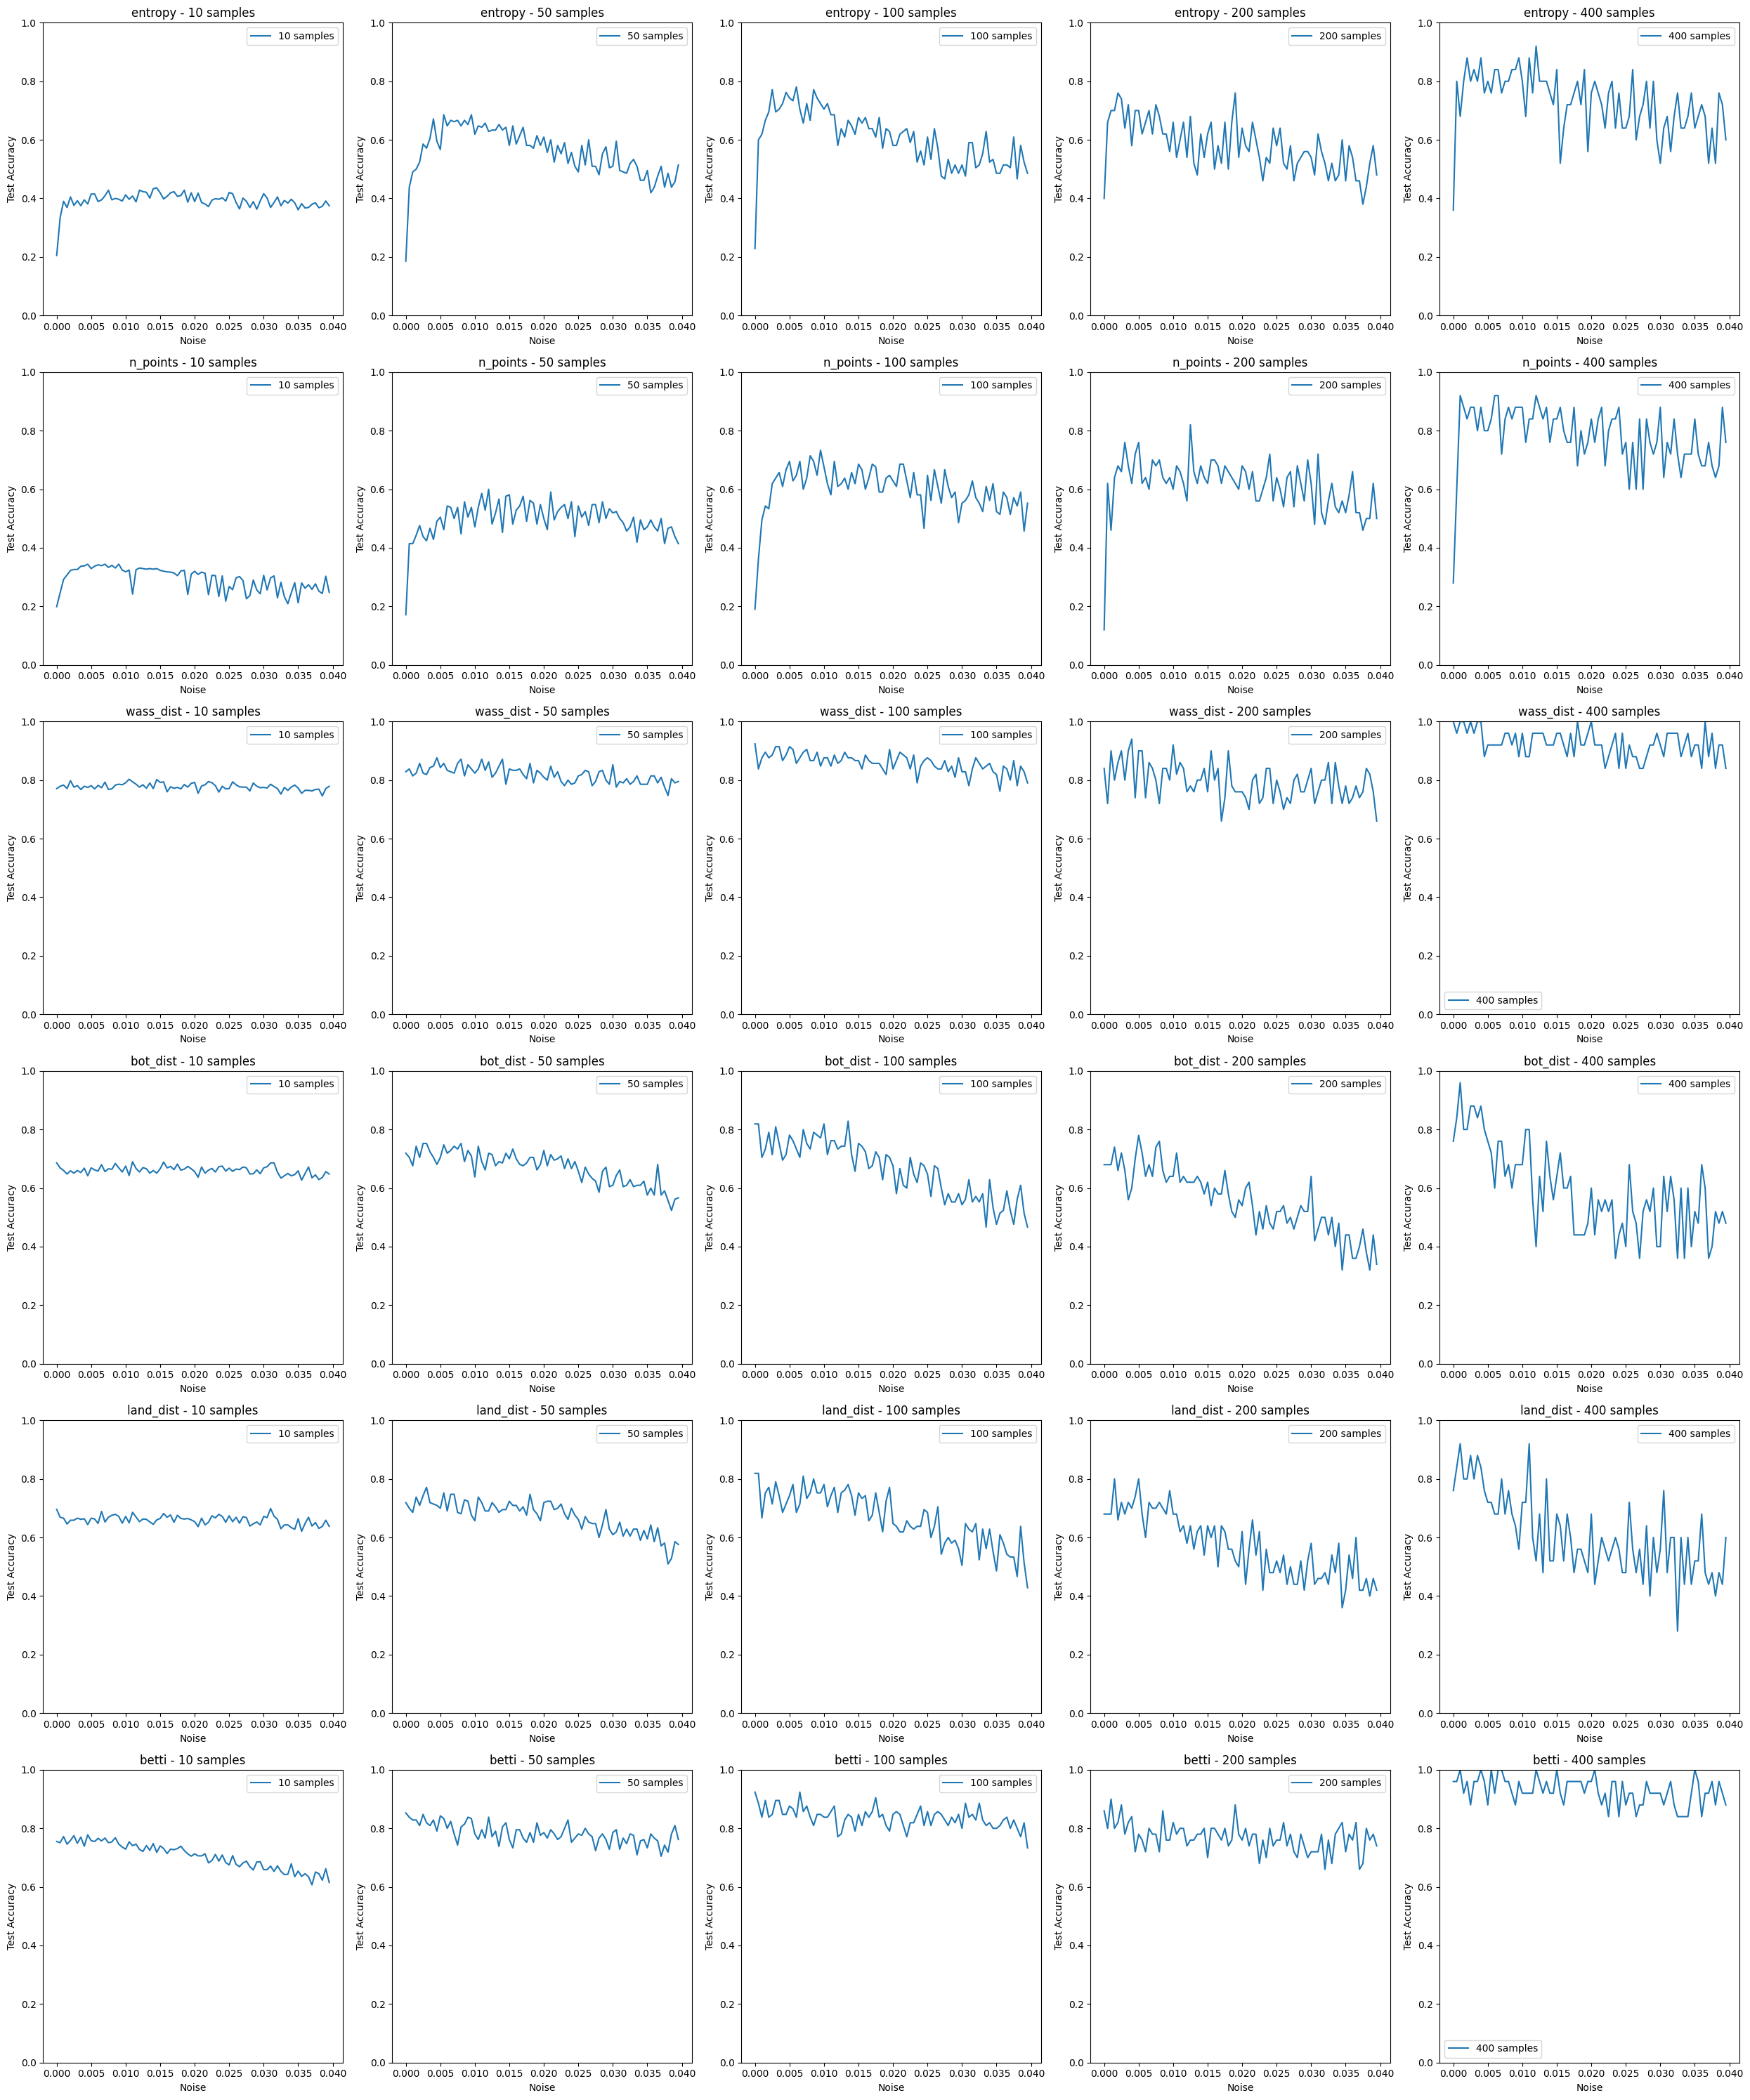

In [32]:
results_overview(results_table)

# - For Wassertein and Betti, we see there is little effect of noise on the accuracy

In [73]:
results_table[(results_table['norm'] == 'wass_dist') & (results_table['num_samp'] == 100)]

,num_samp,noise,norm,test_accuracy
350,100,0.0000,wass_dist,0.857143
356,100,0.0001,wass_dist,0.809524
362,100,0.0002,wass_dist,0.904762
368,100,0.0003,wass_dist,0.952381
374,100,0.0004,wass_dist,0.714286
380,100,0.0005,wass_dist,0.714286
386,100,0.0006,wass_dist,0.857143
392,100,0.0007,wass_dist,0.809524
398,100,0.0008,wass_dist,0.857143
404,100,0.0009,wass_dist,0.809524


In [107]:
def experiment_2(norm, num_samp, noise, size, k):
    norm_data = np.empty((0,3))
    label_data = np.array([])
    for _ in range(size):

        data, labels = loadFigures(OPTION, num_samp, FIGURES, MAXIMUM_SAMPLES_PER_FIGURE, noise_std=noise)
        groups_per_figure = int(data.shape[0]/len(FIGURES))
        fig_1_dat = data[:groups_per_figure]
        fig_2_dat = data[groups_per_figure : 2 * groups_per_figure]
        fig_3_dat = data[2 * groups_per_figure : 3 * groups_per_figure]
        fig_4_dat = data[3 * groups_per_figure : 4 * groups_per_figure]
        fig_5_dat = data[4 * groups_per_figure : 5 * groups_per_figure]

        for k, data in enumerate([fig_1_dat, fig_2_dat, fig_3_dat, fig_4_dat, fig_5_dat]):
            if norm == 'entropy':
                diagrams = getPersistenceDiagrams(data)
                norms = getPersistenceEntropy(diagrams)
            elif norm == 'n_points':
                diagrams = getPersistenceDiagrams(data)
                norms = NumberOfPoints().fit_transform(diagrams)
            else:
                norms = Amplitude(metric=norm).fit_transform(getPersistenceDiagrams(data))
            norm_data = np.concatenate((norm_data, norms))
            label_data = np.concatenate((label_data, np.full(norms.shape[0], k+1)))
    
    X_train, X_test, y_train, y_test = train_test_split(norm_data,label_data, test_size=0.2)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    test_accuracy = knn.score(X_test, y_test)

    return test_accuracy



    
        


In [108]:
experiment_2('entropy', 10, 0.0005, 1, 2)

0.3

In [91]:
""" Testing the effect of k on the accuracy of the kNN classifier """
def test_k(k_range, norm='wasserstein', num_samp=10, noise=0.0005, size=1):
    accuracies = []
    var = []
    for k in k_range:
        temp_accuracies = []
        for _ in range(100):
            temp_accuracies.append(experiment_2(norm, num_samp, noise, size, k))
        accuracies.append(np.mean(temp_accuracies))
        var.append(np.var(temp_accuracies))
    return np.array(accuracies), np.array(var)


In [92]:
accuracies, var = test_k([1,2,3,4,5,6,7,8,12,15,20])

In [93]:
print(accuracies)

[0.76805 0.7696  0.7683  0.7742  0.7727  0.77185 0.77525 0.7701  0.7698
 0.77085 0.7681 ]


In [94]:
print(var)

[0.00100945 0.00087634 0.00079061 0.00093186 0.00076371 0.00070983
 0.00088619 0.00088399 0.00079046 0.00074753 0.00094539]


In [99]:
"""Testing the effect of size of training data on the accuracy of the kNN classifier"""
def test_size(size_range, norm='betti', num_samp=10, noise=0.0005, k=2):
    accuracies = []
    var = []
    for size in size_range:
        temp_accuracies = []
        for _ in range(10):
            temp_accuracies.append(experiment_2(norm, num_samp, noise, size, k))
        accuracies.append(np.mean(temp_accuracies))
        var.append(np.var(temp_accuracies))
    return np.array(accuracies), np.array(var)

In [100]:
size_range = [1,2,3,4,5,8,10,15]
accuracies, var = test_size(size_range, k=2)

In [101]:
print(accuracies)

[0.7545     0.74025    0.744      0.74675    0.7503     0.7608125
 0.75975    0.76303333]


In [102]:
print(var)

[2.67250000e-04 5.41812500e-04 2.76777778e-04 1.30375000e-04
 2.64410000e-04 2.31957031e-04 4.58125000e-05 4.93655556e-05]


{10: [], 50: [], 100: [], 200: [], 400: []}

In [109]:
""" 
Testing the effect of noise, num_samp, and norm on the accuracy of the kNN classifier
For each combination of noise, num_samp and norm, we train and test the kNN classifier 100 times and compute
the mean and variance of the test accuracies and store it in a DataFrame.
"""
def big_test():
    results_table = pd.DataFrame(columns=['num_samp', 'noise', 'norm', 'test_accuracy', 'variance'])
    for num_samp in num_of_samples_per_group:
        for noise in np.arange(0,0.0505, 0.0005):
            for norm in ['entropy', 'n_points', 'wasserstein', 'bottleneck', 'landscape', 'betti']:
                temp_accuracies = []
                for _ in range(100):
                    temp_accuracies.append(experiment_2(norm, num_samp, noise, 1, 2))
                mean_accuracy = np.mean(temp_accuracies)
                variance = np.var(temp_accuracies)
                results_table.loc[len(results_table)] = [num_samp, noise, norm, mean_accuracy, variance]
    return results_table

In [ ]:
big_results = big_test()